In [29]:
import os
import time
import copy
from collections import defaultdict
import torch
import torchvision
import shutil
import pandas as pd
from skimage import io
from skimage import transform
#import albumentations
#from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
#from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2
#from albumentations.pytorch import ToTensor
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch import nn
import zipfile
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [30]:
data_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(256),
    transforms.ToTensor()
    #transforms.Normalize([124,117,104],[58.4,57.1,57.4])
    ])

In [31]:
class ImageNetData(Dataset):
    
    def __init__(self, info_path):
        f = open(info_path)
        self.data = f.read().splitlines()
        self.transforms = data_transforms
    
    def __len__(self):
        return len(self.data)
        
        
    def __getitem__(self, index):
        
        img = Image.open(os.path.join(r'./',self.data[index].split(' ')[0]))
        img = self.transforms(img)
        label = self.data[index].split(' ')[1]
        label = int(label)
        label = np.eye(100)[label]
        return (img,label)
        

        

In [32]:
train_info_path = r'./train.txt'
val_info_path = r'./val.txt'
train_set = ImageNetData(train_info_path)
val_set = ImageNetData(val_info_path)

In [33]:
print(train_set.__len__())
print(val_set.__len__())

100000
10000


In [34]:
def plot_image(mode, index):
    if (mode == 'train'):
        img = train_set.__getitem__(index)[0]
        print('label:',train_set.__getitem__(index)[1])
    elif (mode == 'val'):
        img = val_set.__getitem__(index)[0]
        print('label:',val_set.__getitem__(index)[1])
    
    img = img.transpose(0,1)
    img = img.transpose(1,2)
    img = img.numpy()
    plt.xticks(())
    plt.yticks(())
    plt.imshow(img)  
    print(img.shape)

label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(256, 256, 3)


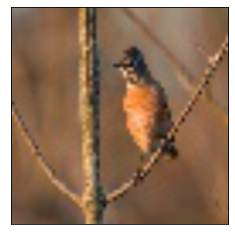

In [36]:
plot_image('train',3002)

In [37]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=100)

In [38]:
class Stem(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv_1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.conv_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False)
        self.conv_3 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        
        self.mixed_4a = nn.MaxPool2d(3, stride=2, padding=1)
        self.mixed_4b = nn.Conv2d(64, 96, 3, stride=2, padding=1, bias=False)
        
        self.mixed_5a = nn.Sequential(
            nn.Conv2d(160, 64, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(64, 96, 3, stride=1, padding=1, bias=False)
        )
        self.mixed_5b = nn.Sequential(
            nn.Conv2d(160, 64, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(64, 64, (1,7), stride=1, padding=(0,3), bias=False),
            nn.Conv2d(64, 64, (7,1), stride=1, padding=(3,0), bias=False),
            nn.Conv2d(64, 96, 3, stride=1, padding=1, bias=False)
        )
        
        self.mixed_6a = nn.Conv2d(192, 192, 3, stride=2, padding=1, bias=False)
        self.mixed_6b = nn.MaxPool2d(3, stride=2, padding=1)
        
        
    def forward(self, x):
        #256x256x3
        x = self.conv_1(x)#128x128x32
        x = self.conv_2(x)#128x128x32
        x = self.conv_3(x)#128x128x64
        x = torch.cat((self.mixed_4a(x), self.mixed_4b(x)), dim=1)#64x64x160
        x = torch.cat((self.mixed_5a(x), self.mixed_5b(x)), dim=1)#64x64x192
        x = torch.cat((self.mixed_6a(x), self.mixed_6b(x)), dim=1)#32x32x384
        
        return x
        
    

In [39]:
class SE_block(nn.Module):
    def __init__(self, in_channels, ratio):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels//ratio, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels//ratio, in_channels, bias=True),
            nn.Sigmoid()            
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        x = x * y.expand_as(x)
        
        return x
        

In [40]:
class Inception_A_with_SE(nn.Module):
    
    def __init__(self, scale):
        super().__init__()
        
        self.scale = scale
        
        self.mixed_1a = nn.Conv2d(384, 32, 1, stride=1, padding=0, bias=False)
        self.mixed_1b = nn.Sequential(
            nn.Conv2d(384, 32, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False)
        )
        self.mixed_1c = nn.Sequential(
            nn.Conv2d(384, 32, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(32, 48, 3, stride=1, padding=1, bias=False),
            nn.Conv2d(48, 64, 3, stride=1, padding=1, bias=False)
        )
        
        self.conv_2 = nn.Conv2d(128, 384, 1, stride=1, padding=0, bias=True)
        
        self.SE_3 = SE_block(384, 16)
        
        self.relu = nn.ReLU(inplace=True)
        
        
    def forward(self, x):
        
        
        x_res = torch.cat(
            (self.mixed_1a(x), self.mixed_1b(x), self.mixed_1c(x)),
            dim=1
        )
        x_res = self.conv_2(x_res)
        x_res = self.SE_3(x_res)
        x = self.relu(x + x_res * self.scale)
        
        return x  #32x32x384
        
        
        
        

In [41]:
class Reduction_A(nn.Module):
    def __init__(self):
        super().__init__()
        self.mixed_1a = nn.MaxPool2d(3, stride=2, padding=1)
        self.mixed_1b = nn.Conv2d(384, 384, 3, stride=2, padding=1, bias=False)
        self.mixed_1c = nn.Sequential(
            nn.Conv2d(384, 256, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False),
            nn.Conv2d(256, 384, 3, stride=2, padding=1, bias=False)
        )
        
    def forward(self, x):
        x = torch.cat(
            (self.mixed_1a(x), self.mixed_1b(x), self.mixed_1c(x)),
            dim=1
        )
        #16x16x1152
        
        return x
        
        

In [42]:
class Inception_B_with_SE(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.mixed_1a = nn.Conv2d(1152, 192, 1, stride=1, padding=0, bias=False)
        self.mixed_1b = nn.Sequential(
            nn.Conv2d(1152, 128, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(128, 160, (1,7), stride=1, padding=(0,3), bias=False),
            nn.Conv2d(160, 192, (7,1), stride=1, padding=(3,0), bias=False)
        )
        
        self.conv_2 = nn.Conv2d(384, 1152, 1, stride=1, padding=0, bias=True)
        
        self.SE_3 = SE_block(1152, 16)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.scale = scale
        
        
    def forward(self, x):
        
        x_res = torch.cat((self.mixed_1a(x), self.mixed_1b(x)), dim=1)
        x_res = self.conv_2(x_res)
        x_res = self.SE_3(x_res)
        x = self.relu(x + x_res * self.scale)#16x16x1152
        
        return x

In [43]:
class Reduction_B(nn.Module):
    def __init__(self):
        super().__init__()
        self.mixed_1a = nn.MaxPool2d(3, stride=2, padding=1)
        self.mixed_1b = nn.Sequential(
            nn.Conv2d(1152, 256, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(256, 384, 3, stride=2, padding=1, bias=False)
        )
        self.mixed_1c = nn.Sequential(
            nn.Conv2d(1152, 256, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(256, 288, 3, stride=2, padding=1, bias=False)
        )
        self.mixed_1d = nn.Sequential(
            nn.Conv2d(1152, 256, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(256, 288, 3, stride=1, padding=1, bias=False),
            nn.Conv2d(288, 320, 3, stride=2, padding=1, bias=False)
        )
        
        
    def forward(self, x):
        x = torch.cat(
            (self.mixed_1a(x), self.mixed_1b(x), self.mixed_1c(x), self.mixed_1d(x)),
            dim=1
        )
        #8x8x2144
        
        return x
        
        

In [44]:
class Inception_C_with_SE(nn.Module):
    def __init__(self, scale, activation):
        super().__init__()
        self.mixed_1a = nn.Conv2d(2144, 192, 1, stride=1, padding=0, bias=False)
        self.mixed_1b = nn.Sequential(
            nn.Conv2d(2144, 192, 1, stride=1, padding=0, bias=False),
            nn.Conv2d(192, 224, (1,3), stride=1, padding=(0,1), bias=False),
            nn.Conv2d(224, 256, (3,1), stride=1, padding=(1,0), bias=False)
        )
        self.conv_2 = nn.Conv2d(448, 2144, 1, stride=1, padding=0, bias=True)
        
        self.relu = nn.ReLU(inplace=True)
        self.scale = scale
        self.activation = activation
        self.SE_3 = SE_block(2144, 16)
        
    def forward(self, x):
        
        x_res = torch.cat((self.mixed_1a(x), self.mixed_1b(x)), dim=1)
        x_res = self.conv_2(x_res)
        x_res = self.SE_3(x_res)
        x = x + x_res * self.scale
        
        #8x8x2144
        if self.activation:
            return self.relu(x)
        return x
        
        

In [54]:
class SE_Inception_ResNet_v2(nn.Module):
    def __init__(self, scale=[1,1,1]):
        super().__init__()
        blocks = []
        blocks.append(Stem())
        for i in range(5):
            blocks.append(Inception_A_with_SE(scale[0]))
        blocks.append(Reduction_A())
        for i in range(10):
            blocks.append(Inception_B_with_SE(scale[1]))
        blocks.append(Reduction_B())
        for i in range(4):
            blocks.append(Inception_C_with_SE(scale[2], True))
        blocks.append(Inception_C_with_SE(scale[2], False))
        self.features = nn.Sequential(*blocks)
        self.global_average_polling = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2144, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.8, inplace=True)
        )
        self.fc2 = nn.Linear(512, 100)
        self.output = nn.Softmax(dim=1)
        
        
        
    def forward(self, x):
        x = self.features(x)#8x8x2144
        x = self.global_average_polling(x)#1x1x2144
        
        x = self.fc1(x)#512
        x = self.fc2(x)#100
        x = self.output(x)
        return x

In [55]:
model = SE_Inception_ResNet_v2()

In [56]:
EPOCHS = 1
LR = 0.05
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_reduct = lambda epochs: 0.1 ** (epochs // 10)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_reduct)
best_model_path = r'./BestModel.pt'

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for epochs in range(EPOCHS):
    
    print('Epoch {}/{}'.format(epochs+1, EPOCHS))
    start_time = time.time()
    running_train_loss = []
    running_train_acc = []
    running_val_loss = []
    running_val_acc = []
    for i, data in enumerate(train_loader):
        inputs = data[0]
        targets = data[1]
        outputs = model(inputs);
        loss = loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = outputs.argmax(axis=1, keepdim=True)
        running_train_loss.append(loss.item())
        running_train_acc.append(float((pred==targets).all()))
    
    for i, data in enumerate(val_loader):
        inputs = data[0]
        targets  =data[1]
        with torch.no_grad():
            outputs = model(inputs);
            loss = loss(outputs, targets)
            pred = outputs.argmax(axis=1, keepdim=True)
            running_val_loss.append(loss.item())
            running_val_acc.append(float((pred==targets).all()))
    
    scheduler.step()    
    train_loss.append(sum(running_train_loss) / len(running_train_loss))
    train_acc.append(sum(running_train_acc) / len(running_train_acc))
    val_loss.append(sum(running_val_loss) / len(running_val_loss))
    val_acc.append(sum(running_val_acc) / len(running_val_acc))
    duration = time.time() - start_time
    
    print('Train loss : {} Train accuracy : {}'.format(train_loss[epochs],train_acc[epochs]))
    print('Val   loss : {} Val   accuracy : {}'.format(val_loss[epochs],val_acc[epochs]))
    print('{:.0f}m {:.0f}s'.format(duration // 60, duration % 60))
    
    
        
    
    
    
    